### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|█████████████████████████| 26421880/26421880 [00:02<00:00, 10764371.15it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|█████████████████████████████████| 29515/29515 [00:00<00:00, 641072.17it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 7871761.02it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|█████████████████████████████████| 5148/5148 [00:00<00:00, 17109569.72it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

In [ ]:
28*28

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator()
discriminator = Discriminator()

In [8]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [9]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [11]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output.flatten(), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output.flatten(), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output.flatten(), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.21 errD_z: 0.13 errG: 2.22
Epoch:1 Iter: 200 errD_x: 0.28 errD_z: 0.17 errG: 2.23
Epoch:1 Iter: 300 errD_x: 0.14 errD_z: 0.18 errG: 2.16
Epoch:1 Iter: 400 errD_x: 0.24 errD_z: 0.06 errG: 3.07
Epoch:1 Iter: 500 errD_x: 0.35 errD_z: 0.07 errG: 2.74
Epoch:1 Iter: 600 errD_x: 0.08 errD_z: 0.07 errG: 2.75
Epoch:1 Iter: 700 errD_x: 0.38 errD_z: 0.07 errG: 2.81
Epoch:1 Iter: 800 errD_x: 0.18 errD_z: 0.12 errG: 2.59
Epoch:1 Iter: 900 errD_x: 0.22 errD_z: 0.16 errG: 2.12
Epoch:1 Iter: 1000 errD_x: 0.20 errD_z: 0.16 errG: 2.23
Epoch:1 Iter: 1100 errD_x: 0.20 errD_z: 0.13 errG: 2.16
Epoch:1 Iter: 1200 errD_x: 0.13 errD_z: 0.23 errG: 1.82
Epoch:1 Iter: 1300 errD_x: 0.06 errD_z: 0.13 errG: 2.32
Epoch:1 Iter: 1400 errD_x: 0.25 errD_z: 0.24 errG: 1.84
Epoch:1 Iter: 1500 errD_x: 0.16 errD_z: 0.24 errG: 1.87
Epoch:1 Iter: 1600 errD_x: 0.10 errD_z: 0.17 errG: 2.40
Epoch:1 Iter: 1700 errD_x: 0.11 errD_z: 0.22 errG: 2.25
Epoch:1 Iter: 1800 errD_x: 0.40 errD_z: 0.23 errG: 1.85
E

Epoch:4 Iter: 3700 errD_x: 0.79 errD_z: 0.08 errG: 3.25
Epoch:5 Iter: 100 errD_x: 0.02 errD_z: 0.39 errG: 3.24
Epoch:5 Iter: 200 errD_x: 0.03 errD_z: 0.38 errG: 2.61
Epoch:5 Iter: 300 errD_x: 0.07 errD_z: 0.16 errG: 2.98
Epoch:5 Iter: 400 errD_x: 0.50 errD_z: 0.14 errG: 3.28
Epoch:5 Iter: 500 errD_x: 0.60 errD_z: 0.06 errG: 3.68
Epoch:5 Iter: 600 errD_x: 0.00 errD_z: 0.25 errG: 2.40
Epoch:5 Iter: 700 errD_x: 0.07 errD_z: 0.20 errG: 2.63
Epoch:5 Iter: 800 errD_x: 0.00 errD_z: 0.38 errG: 2.77
Epoch:5 Iter: 900 errD_x: 0.15 errD_z: 0.02 errG: 4.98
Epoch:5 Iter: 1000 errD_x: 0.12 errD_z: 0.11 errG: 3.37
Epoch:5 Iter: 1100 errD_x: 0.38 errD_z: 0.10 errG: 2.81
Epoch:5 Iter: 1200 errD_x: 0.41 errD_z: 0.06 errG: 4.40
Epoch:5 Iter: 1300 errD_x: 0.00 errD_z: 0.27 errG: 2.68
Epoch:5 Iter: 1400 errD_x: 0.13 errD_z: 0.14 errG: 3.53
Epoch:5 Iter: 1500 errD_x: 0.22 errD_z: 0.04 errG: 4.62
Epoch:5 Iter: 1600 errD_x: 0.54 errD_z: 0.22 errG: 3.08
Epoch:5 Iter: 1700 errD_x: 0.18 errD_z: 0.06 errG: 3.46
E

Epoch:8 Iter: 3600 errD_x: 0.01 errD_z: 0.12 errG: 3.37
Epoch:8 Iter: 3700 errD_x: 0.01 errD_z: 0.30 errG: 2.32
Epoch:9 Iter: 100 errD_x: 0.01 errD_z: 0.48 errG: 2.67
Epoch:9 Iter: 200 errD_x: 0.10 errD_z: 0.23 errG: 3.13
Epoch:9 Iter: 300 errD_x: 0.08 errD_z: 0.17 errG: 2.60
Epoch:9 Iter: 400 errD_x: 0.59 errD_z: 0.08 errG: 4.28
Epoch:9 Iter: 500 errD_x: 0.15 errD_z: 0.28 errG: 2.69
Epoch:9 Iter: 600 errD_x: 0.09 errD_z: 0.03 errG: 5.26
Epoch:9 Iter: 700 errD_x: 0.57 errD_z: 0.25 errG: 2.55
Epoch:9 Iter: 800 errD_x: 0.30 errD_z: 0.65 errG: 1.39
Epoch:9 Iter: 900 errD_x: 0.27 errD_z: 0.19 errG: 3.70
Epoch:9 Iter: 1000 errD_x: 0.03 errD_z: 0.30 errG: 1.96
Epoch:9 Iter: 1100 errD_x: 0.68 errD_z: 0.09 errG: 3.40
Epoch:9 Iter: 1200 errD_x: 0.26 errD_z: 0.31 errG: 2.39
Epoch:9 Iter: 1300 errD_x: 0.31 errD_z: 0.08 errG: 3.17
Epoch:9 Iter: 1400 errD_x: 0.24 errD_z: 0.38 errG: 1.83
Epoch:9 Iter: 1500 errD_x: 0.17 errD_z: 0.34 errG: 2.46
Epoch:9 Iter: 1600 errD_x: 0.50 errD_z: 0.08 errG: 4.26
E

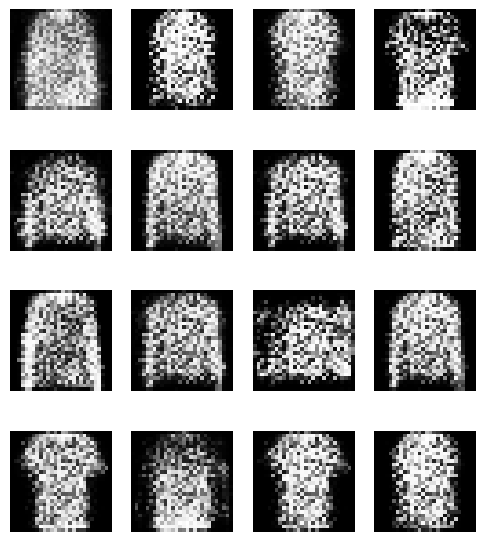

In [12]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

**WGAN weight clipping**

In [109]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

def weight_clip(critic):
    for param in critic.parameters():
        param.data.clamp_(-0.01, 0.01)

In [110]:
generator = Generator()
discriminator = Discriminator()

In [111]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=0.00005)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=0.00005)

criterion = nn.BCELoss()

In [112]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [119]:
critic_iter = 10
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        
        one = torch.FloatTensor([1])
        mone = one * -1
        
        discriminator.zero_grad()
        
        for d_iter in range(critic_iter):
            #weight_clipping
            weight_clip(discriminator)

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            real_logit = discriminator(input_data)
            errD_x = real_logit.mean(0).view(1)
    #         print(errD_x)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward(one)


            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            fake_logit = discriminator(fake.detach())
            errD_z = fake_logit.mean(0).view(1)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward(mone)

            discriminator_loss = errD_z - errD_x
            Wasserstein_D = errD_x - errD_z

            optim_D.step()
        
        generator.zero_grad()
        label.data.fill_(real_label)
        fake_logit = discriminator(fake)
        errG = fake_logit.mean().mean(0).view(1)
#         print(errD_z.detach().numpy()[0])
#         errG = criterion(output.flatten(), label)
        ERRG[epoch] += errG.item()
        errG.backward(one)
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_z: {:.5f} errD_x: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                    iteration+1, 
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0]))
                  

Epoch:1 Iter: 100 errD_z: 0.49429 errD_x: 0.49429 errG: 0.49429
Epoch:1 Iter: 200 errD_z: 0.48875 errD_x: 0.48875 errG: 0.48875
Epoch:1 Iter: 300 errD_z: 0.50293 errD_x: 0.50293 errG: 0.50293
Epoch:1 Iter: 400 errD_z: 0.51491 errD_x: 0.51491 errG: 0.51491
Epoch:1 Iter: 500 errD_z: 0.51800 errD_x: 0.51800 errG: 0.51800
Epoch:1 Iter: 600 errD_z: 0.51652 errD_x: 0.51652 errG: 0.51652
Epoch:1 Iter: 700 errD_z: 0.51292 errD_x: 0.51292 errG: 0.51292
Epoch:1 Iter: 800 errD_z: 0.51191 errD_x: 0.51191 errG: 0.51191
Epoch:1 Iter: 900 errD_z: 0.51026 errD_x: 0.51026 errG: 0.51026
Epoch:1 Iter: 1000 errD_z: 0.50934 errD_x: 0.50934 errG: 0.50934
Epoch:1 Iter: 1100 errD_z: 0.50831 errD_x: 0.50831 errG: 0.50831
Epoch:1 Iter: 1200 errD_z: 0.50654 errD_x: 0.50654 errG: 0.50654
Epoch:1 Iter: 1300 errD_z: 0.50802 errD_x: 0.50802 errG: 0.50802
Epoch:1 Iter: 1400 errD_z: 0.50692 errD_x: 0.50692 errG: 0.50692
Epoch:1 Iter: 1500 errD_z: 0.50735 errD_x: 0.50735 errG: 0.50735
Epoch:1 Iter: 1600 errD_z: 0.50683

Epoch:4 Iter: 1700 errD_z: 0.49868 errD_x: 0.49868 errG: 0.49868
Epoch:4 Iter: 1800 errD_z: 0.49970 errD_x: 0.49970 errG: 0.49970
Epoch:4 Iter: 1900 errD_z: 0.49772 errD_x: 0.49772 errG: 0.49772
Epoch:4 Iter: 2000 errD_z: 0.50379 errD_x: 0.50379 errG: 0.50379
Epoch:4 Iter: 2100 errD_z: 0.49988 errD_x: 0.49988 errG: 0.49988
Epoch:4 Iter: 2200 errD_z: 0.50041 errD_x: 0.50041 errG: 0.50041
Epoch:4 Iter: 2300 errD_z: 0.50232 errD_x: 0.50232 errG: 0.50232
Epoch:4 Iter: 2400 errD_z: 0.50241 errD_x: 0.50241 errG: 0.50241
Epoch:4 Iter: 2500 errD_z: 0.50272 errD_x: 0.50272 errG: 0.50272
Epoch:4 Iter: 2600 errD_z: 0.50284 errD_x: 0.50284 errG: 0.50284
Epoch:4 Iter: 2700 errD_z: 0.50063 errD_x: 0.50063 errG: 0.50063
Epoch:4 Iter: 2800 errD_z: 0.49635 errD_x: 0.49635 errG: 0.49635
Epoch:4 Iter: 2900 errD_z: 0.49963 errD_x: 0.49963 errG: 0.49963
Epoch:4 Iter: 3000 errD_z: 0.50259 errD_x: 0.50259 errG: 0.50259
Epoch:4 Iter: 3100 errD_z: 0.49959 errD_x: 0.49959 errG: 0.49959
Epoch:4 Iter: 3200 errD_z

Epoch:7 Iter: 3300 errD_z: 0.50278 errD_x: 0.50278 errG: 0.50278
Epoch:7 Iter: 3400 errD_z: 0.49879 errD_x: 0.49879 errG: 0.49879
Epoch:7 Iter: 3500 errD_z: 0.50324 errD_x: 0.50324 errG: 0.50324
Epoch:7 Iter: 3600 errD_z: 0.49977 errD_x: 0.49977 errG: 0.49977
Epoch:7 Iter: 3700 errD_z: 0.50314 errD_x: 0.50314 errG: 0.50314
Epoch:8 Iter: 100 errD_z: 0.50005 errD_x: 0.50005 errG: 0.50005
Epoch:8 Iter: 200 errD_z: 0.49941 errD_x: 0.49941 errG: 0.49941
Epoch:8 Iter: 300 errD_z: 0.50131 errD_x: 0.50131 errG: 0.50131
Epoch:8 Iter: 400 errD_z: 0.49994 errD_x: 0.49994 errG: 0.49994
Epoch:8 Iter: 500 errD_z: 0.50233 errD_x: 0.50233 errG: 0.50233
Epoch:8 Iter: 600 errD_z: 0.50145 errD_x: 0.50145 errG: 0.50145
Epoch:8 Iter: 700 errD_z: 0.50000 errD_x: 0.50000 errG: 0.50000
Epoch:8 Iter: 800 errD_z: 0.50090 errD_x: 0.50090 errG: 0.50090
Epoch:8 Iter: 900 errD_z: 0.50053 errD_x: 0.50053 errG: 0.50053
Epoch:8 Iter: 1000 errD_z: 0.50320 errD_x: 0.50320 errG: 0.50320
Epoch:8 Iter: 1100 errD_z: 0.50254

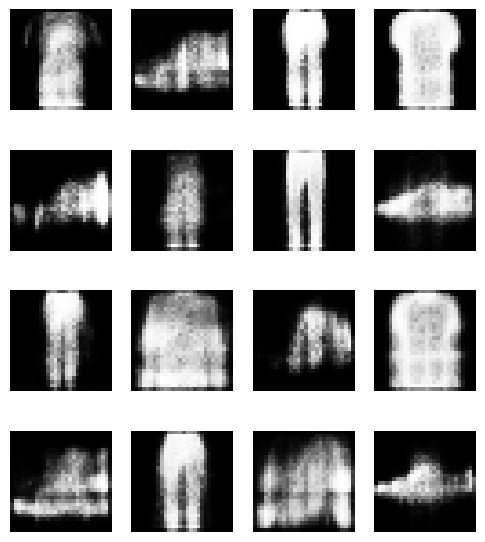

In [120]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

**WGAN gradient penalty**

In [121]:
generator = Generator()
discriminator = Discriminator()

In [122]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.00005)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00005)

criterion = nn.BCELoss()

In [123]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [124]:
from torch import autograd

lambda_term = 10
critic_iter = 5
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        
        one = torch.FloatTensor([1])
        mone = one * -1
        
        discriminator.zero_grad()
        
        for d_iter in range(critic_iter):

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            real_logit = discriminator(input_data)
            errD_x = real_logit.mean(0).view(1)
    #         print(errD_x)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward(one)


            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            fake_logit = discriminator(fake.detach())
            errD_z = fake_logit.mean(0).view(1)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward(mone)
            
            #grad_penalty
            eta = torch.FloatTensor(images.shape[0],1,1,1).uniform_(0,1)
            eta = eta.expand(images.shape[0], images.size(1), images.size(2), images.size(3))
            eta = eta
            
            
            fake_res = fake.resize(images.shape[0], images.size(1), images.size(2), images.size(3))

            interpolated = eta * images + ((1 - eta) * fake_res)

            interpolated = Variable(interpolated, requires_grad=True)
            
            interpolated = interpolated.view(interpolated.shape[0], -1)

            prob_interpolated = discriminator(interpolated)
            
            gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

            gradients = gradients.view(gradients.size(0), -1)

            grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_term
                                      
            grad_penalty.backward()
            

            discriminator_loss = errD_z - errD_x
            Wasserstein_D = errD_x - errD_z

            optim_D.step()
        
        generator.zero_grad()
        label.data.fill_(real_label)
        fake_logit = discriminator(fake)
        errG = fake_logit.mean().mean(0).view(1)
#         print(errD_z.detach().numpy()[0])
#         errG = criterion(output.flatten(), label)
        ERRG[epoch] += errG.item()
        errG.backward(one)
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_z: {:.5f} errD_x: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                    iteration+1, 
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0]))
                  

Epoch:1 Iter: 100 errD_z: 0.60657 errD_x: 0.60657 errG: 0.60657
Epoch:1 Iter: 200 errD_z: 0.53875 errD_x: 0.53875 errG: 0.53875
Epoch:1 Iter: 300 errD_z: 0.51806 errD_x: 0.51806 errG: 0.51806
Epoch:1 Iter: 400 errD_z: 0.66813 errD_x: 0.66813 errG: 0.66813
Epoch:1 Iter: 500 errD_z: 0.61767 errD_x: 0.61767 errG: 0.61767
Epoch:1 Iter: 600 errD_z: 0.54676 errD_x: 0.54676 errG: 0.54676
Epoch:1 Iter: 700 errD_z: 0.52485 errD_x: 0.52485 errG: 0.52485
Epoch:1 Iter: 800 errD_z: 0.48118 errD_x: 0.48118 errG: 0.48118
Epoch:1 Iter: 900 errD_z: 0.48295 errD_x: 0.48295 errG: 0.48295
Epoch:1 Iter: 1000 errD_z: 0.49167 errD_x: 0.49167 errG: 0.49167
Epoch:1 Iter: 1100 errD_z: 0.50139 errD_x: 0.50139 errG: 0.50139
Epoch:1 Iter: 1200 errD_z: 0.53771 errD_x: 0.53771 errG: 0.53771
Epoch:1 Iter: 1300 errD_z: 0.45728 errD_x: 0.45728 errG: 0.45728
Epoch:1 Iter: 1400 errD_z: 0.45886 errD_x: 0.45886 errG: 0.45886
Epoch:1 Iter: 1500 errD_z: 0.47531 errD_x: 0.47531 errG: 0.47531
Epoch:1 Iter: 1600 errD_z: 0.49998

Epoch:4 Iter: 1700 errD_z: 0.58031 errD_x: 0.58031 errG: 0.58031
Epoch:4 Iter: 1800 errD_z: 0.63432 errD_x: 0.63432 errG: 0.63432
Epoch:4 Iter: 1900 errD_z: 0.57460 errD_x: 0.57460 errG: 0.57460
Epoch:4 Iter: 2000 errD_z: 0.66239 errD_x: 0.66239 errG: 0.66239
Epoch:4 Iter: 2100 errD_z: 0.61855 errD_x: 0.61855 errG: 0.61855
Epoch:4 Iter: 2200 errD_z: 0.69569 errD_x: 0.69569 errG: 0.69569
Epoch:4 Iter: 2300 errD_z: 0.77871 errD_x: 0.77871 errG: 0.77871
Epoch:4 Iter: 2400 errD_z: 0.72030 errD_x: 0.72030 errG: 0.72030
Epoch:4 Iter: 2500 errD_z: 0.72001 errD_x: 0.72001 errG: 0.72001
Epoch:4 Iter: 2600 errD_z: 0.71378 errD_x: 0.71378 errG: 0.71378
Epoch:4 Iter: 2700 errD_z: 0.63624 errD_x: 0.63624 errG: 0.63624
Epoch:4 Iter: 2800 errD_z: 0.64452 errD_x: 0.64452 errG: 0.64452
Epoch:4 Iter: 2900 errD_z: 0.63865 errD_x: 0.63865 errG: 0.63865
Epoch:4 Iter: 3000 errD_z: 0.68800 errD_x: 0.68800 errG: 0.68800
Epoch:4 Iter: 3100 errD_z: 0.57291 errD_x: 0.57291 errG: 0.57291
Epoch:4 Iter: 3200 errD_z

Epoch:7 Iter: 3300 errD_z: 0.68553 errD_x: 0.68553 errG: 0.68553
Epoch:7 Iter: 3400 errD_z: 0.70532 errD_x: 0.70532 errG: 0.70532
Epoch:7 Iter: 3500 errD_z: 0.65769 errD_x: 0.65769 errG: 0.65769
Epoch:7 Iter: 3600 errD_z: 0.72773 errD_x: 0.72773 errG: 0.72773
Epoch:7 Iter: 3700 errD_z: 0.76184 errD_x: 0.76184 errG: 0.76184
Epoch:8 Iter: 100 errD_z: 0.64344 errD_x: 0.64344 errG: 0.64344
Epoch:8 Iter: 200 errD_z: 0.76448 errD_x: 0.76448 errG: 0.76448
Epoch:8 Iter: 300 errD_z: 0.68972 errD_x: 0.68972 errG: 0.68972
Epoch:8 Iter: 400 errD_z: 0.63794 errD_x: 0.63794 errG: 0.63794
Epoch:8 Iter: 500 errD_z: 0.72915 errD_x: 0.72915 errG: 0.72915
Epoch:8 Iter: 600 errD_z: 0.75303 errD_x: 0.75303 errG: 0.75303
Epoch:8 Iter: 700 errD_z: 0.77992 errD_x: 0.77992 errG: 0.77992
Epoch:8 Iter: 800 errD_z: 0.67111 errD_x: 0.67111 errG: 0.67111
Epoch:8 Iter: 900 errD_z: 0.69125 errD_x: 0.69125 errG: 0.69125
Epoch:8 Iter: 1000 errD_z: 0.68839 errD_x: 0.68839 errG: 0.68839
Epoch:8 Iter: 1100 errD_z: 0.73085

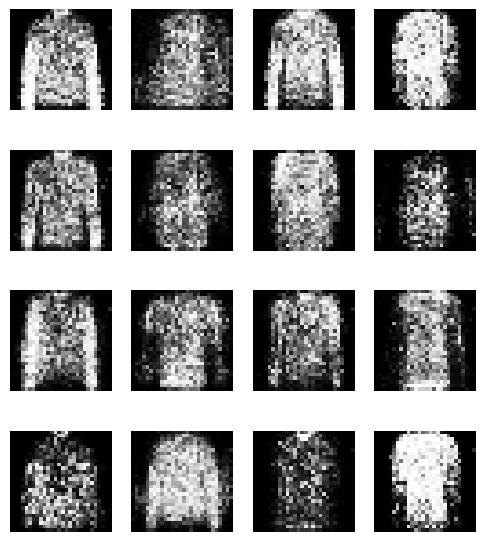

In [125]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

**WGAN with marked labels**

Добавим метку к реализации с weight clipping, так как в случае. wight clipping генерация получилась лучше

In [186]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, 256)
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + 256, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)  # Embed labels
        x = torch.cat((x, label_embedding), dim=1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 256)
        self.model = nn.Sequential(
            nn.Linear(28*28 + 256, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x, labels):
        label_embedding = self.label_embedding(labels)  # Embed labels
        x = torch.cat((x, label_embedding), dim=1)
        return self.model(x)

def weight_clip(critic):
    for param in critic.parameters():
        param.data.clamp_(-0.01, 0.01)

In [187]:
generator = Generator()
discriminator = Discriminator()

In [188]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.00005)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00005)

criterion = nn.BCELoss()

In [189]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [191]:
critic_iter = 10
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        
        one = torch.FloatTensor([1])
        mone = one * -1
        
        discriminator.zero_grad()
        
        for d_iter in range(critic_iter):
            #weight_clipping
            weight_clip(discriminator)

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            real_logit = discriminator(input_data, cat)
            errD_x = real_logit.mean(0).view(1)
    #         print(errD_x)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward(one)


            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise, cat)
            label.data.fill_(fake_label)
            fake_logit = discriminator(fake.detach(), cat)
            errD_z = fake_logit.mean(0).view(1)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward(mone)

            discriminator_loss = errD_z - errD_x
            Wasserstein_D = errD_x - errD_z

            optim_D.step()
        
        generator.zero_grad()
        label.data.fill_(real_label)
        fake_logit = discriminator(fake, cat)
        errG = fake_logit.mean().mean(0).view(1)
#         print(errD_z.detach().numpy()[0])
#         errG = criterion(output.flatten(), label)
        ERRG[epoch] += errG.item()
        errG.backward(one)
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_z: {:.5f} errD_x: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                    iteration+1, 
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0],
                                                                                    errD_z.detach().numpy()[0]))
                  

Epoch:1 Iter: 100 errD_z: 0.56516 errD_x: 0.56516 errG: 0.56516
Epoch:1 Iter: 200 errD_z: 0.52873 errD_x: 0.52873 errG: 0.52873
Epoch:1 Iter: 300 errD_z: 0.54277 errD_x: 0.54277 errG: 0.54277
Epoch:1 Iter: 400 errD_z: 0.53439 errD_x: 0.53439 errG: 0.53439
Epoch:1 Iter: 500 errD_z: 0.52931 errD_x: 0.52931 errG: 0.52931
Epoch:1 Iter: 600 errD_z: 0.51901 errD_x: 0.51901 errG: 0.51901
Epoch:1 Iter: 700 errD_z: 0.50846 errD_x: 0.50846 errG: 0.50846
Epoch:1 Iter: 800 errD_z: 0.49492 errD_x: 0.49492 errG: 0.49492
Epoch:1 Iter: 900 errD_z: 0.49635 errD_x: 0.49635 errG: 0.49635
Epoch:1 Iter: 1000 errD_z: 0.49945 errD_x: 0.49945 errG: 0.49945
Epoch:1 Iter: 1100 errD_z: 0.50829 errD_x: 0.50829 errG: 0.50829
Epoch:1 Iter: 1200 errD_z: 0.50685 errD_x: 0.50685 errG: 0.50685
Epoch:1 Iter: 1300 errD_z: 0.50748 errD_x: 0.50748 errG: 0.50748
Epoch:1 Iter: 1400 errD_z: 0.50756 errD_x: 0.50756 errG: 0.50756
Epoch:1 Iter: 1500 errD_z: 0.50508 errD_x: 0.50508 errG: 0.50508
Epoch:1 Iter: 1600 errD_z: 0.50538

Epoch:4 Iter: 1700 errD_z: 0.49761 errD_x: 0.49761 errG: 0.49761
Epoch:4 Iter: 1800 errD_z: 0.50057 errD_x: 0.50057 errG: 0.50057
Epoch:4 Iter: 1900 errD_z: 0.50490 errD_x: 0.50490 errG: 0.50490
Epoch:4 Iter: 2000 errD_z: 0.50383 errD_x: 0.50383 errG: 0.50383
Epoch:4 Iter: 2100 errD_z: 0.50537 errD_x: 0.50537 errG: 0.50537
Epoch:4 Iter: 2200 errD_z: 0.50285 errD_x: 0.50285 errG: 0.50285
Epoch:4 Iter: 2300 errD_z: 0.50450 errD_x: 0.50450 errG: 0.50450
Epoch:4 Iter: 2400 errD_z: 0.50230 errD_x: 0.50230 errG: 0.50230
Epoch:4 Iter: 2500 errD_z: 0.50499 errD_x: 0.50499 errG: 0.50499
Epoch:4 Iter: 2600 errD_z: 0.50179 errD_x: 0.50179 errG: 0.50179
Epoch:4 Iter: 2700 errD_z: 0.50474 errD_x: 0.50474 errG: 0.50474
Epoch:4 Iter: 2800 errD_z: 0.50231 errD_x: 0.50231 errG: 0.50231
Epoch:4 Iter: 2900 errD_z: 0.50253 errD_x: 0.50253 errG: 0.50253
Epoch:4 Iter: 3000 errD_z: 0.50380 errD_x: 0.50380 errG: 0.50380
Epoch:4 Iter: 3100 errD_z: 0.50252 errD_x: 0.50252 errG: 0.50252
Epoch:4 Iter: 3200 errD_z

Epoch:7 Iter: 3300 errD_z: 0.50463 errD_x: 0.50463 errG: 0.50463
Epoch:7 Iter: 3400 errD_z: 0.50145 errD_x: 0.50145 errG: 0.50145
Epoch:7 Iter: 3500 errD_z: 0.50019 errD_x: 0.50019 errG: 0.50019
Epoch:7 Iter: 3600 errD_z: 0.49444 errD_x: 0.49444 errG: 0.49444
Epoch:7 Iter: 3700 errD_z: 0.49793 errD_x: 0.49793 errG: 0.49793
Epoch:8 Iter: 100 errD_z: 0.49979 errD_x: 0.49979 errG: 0.49979
Epoch:8 Iter: 200 errD_z: 0.49677 errD_x: 0.49677 errG: 0.49677
Epoch:8 Iter: 300 errD_z: 0.50931 errD_x: 0.50931 errG: 0.50931
Epoch:8 Iter: 400 errD_z: 0.49259 errD_x: 0.49259 errG: 0.49259
Epoch:8 Iter: 500 errD_z: 0.50092 errD_x: 0.50092 errG: 0.50092
Epoch:8 Iter: 600 errD_z: 0.49436 errD_x: 0.49436 errG: 0.49436
Epoch:8 Iter: 700 errD_z: 0.50500 errD_x: 0.50500 errG: 0.50500
Epoch:8 Iter: 800 errD_z: 0.50214 errD_x: 0.50214 errG: 0.50214
Epoch:8 Iter: 900 errD_z: 0.48930 errD_x: 0.48930 errG: 0.48930
Epoch:8 Iter: 1000 errD_z: 0.50245 errD_x: 0.50245 errG: 0.50245
Epoch:8 Iter: 1100 errD_z: 0.49656

torch.Size([16, 50])


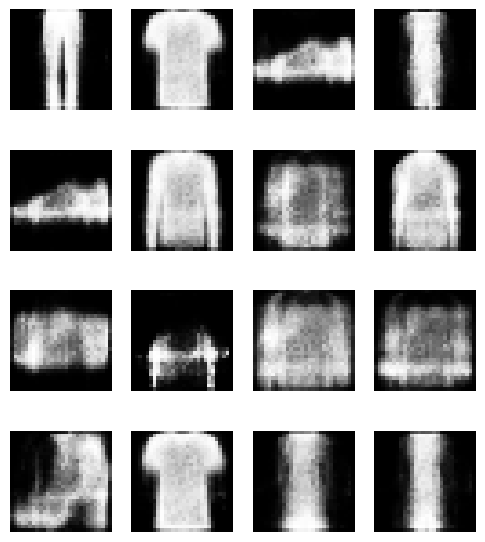

In [198]:
noise.data.normal_(0, 1)
print(noise.size())
fake = generator(noise, torch.randint(size=(16, ), high=9, low=0))

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Наилучший результат при использовании CGAN + weight clipping. При данном подходе получаются четки изображения, практически без шума в большинстве случаев. Реализованы все методы, которые требовались в ДЗ.
Все параметры и алгоритмы взяты из соответствующих статей. Для улучшения результатов обучения возможно стоило вместо линейных слоев использовать свертки, а также вместо ReLU использовать LeakyReLU, но в связи с требованием дз, был модифицирован исходный код для получения выше описанных архитектур.